<a href="https://colab.research.google.com/github/hyunku/Teach-Data-Analysis-Basic/blob/main/BikePredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 따릉이 이용 대여수 예측해보기 OT

# 0. 데이터 분석에 필요한 파이썬 기초 문법

In [ ]:
# 필요 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 리스트 생성
li_ex = [1,2,6,5,3,67,58,43,42]
li_ex2 = [5,2,5,6,8,35,34,786,45]

In [ ]:
# 데이터프레임 만들기
df = pd.DataFrame({'col1':li_ex, 'col2':li_ex2}) # 딕셔너리의 키값으로 제목, 값으로 리스트 값 입력
df

,col1,col2
0,1,5
1,2,2
2,6,5
3,5,6
4,3,8
5,67,35
6,58,34
7,43,786
8,42,45


In [ ]:
# 기초 인덱싱 문법
df['col1'] # col1속성에 해당하는 값 출력 (col1리스트)
df.loc[:,'col1'] # 속성명으로 인덱싱. -> 위와 동일한 결과 출력
df.iloc[1:3,:] # 숫자로 인덱싱 -> [raw(세로방향),col(가로방향)] -> : 은 범위지정할때 사용. iloc[raw,col] 에서 raw자리에 1:3 은 세로방향으로 1번부터 3-1번까지 보겠다는 의미.  col도 마찬가지로 사용가능

,col1,col2
1,2,2
2,6,5


# 일정

1~2 학년 교육용

## 일정 

### 5/20 : 분석환경 소개(코랩) 및 사용법 설명, 데이터 분석 흐름 소개(OT), 파이썬 기초 문법, 데이터 살펴보기, 데이터 전처리
### 5/27 : groupby와 간단한 EDA과정으로 속성별 연관성들 시각화하기 -> 중간과제 : 해당 속성들을 조합하여 새로운 속성을 만들어내보자.

### 기말고사 (방학때 뵈요~!)

### 방학때 groupby를 이용한 Feature Engineering 부터 모델학습 공부예정.

# 1. 데이터 불러오기

In [ ]:
# 구글 드라이브와 mount(연결)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 파일 불러오기
train = pd.read_csv("/content/drive/MyDrive/PythonProjects/datafiles/bike/train.csv")
test = pd.read_csv("/content/drive/MyDrive/PythonProjects/datafiles/bike/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/PythonProjects/datafiles/bike/submission.csv")

# 2. 데이터 기본 정보 살펴보기

속성분류 - 연속형 변수, 범주형 변수

연속형 변수 : 2, 234, 94.32409 등의 연속되는 수치로 나타나는 변수

범주형 변수 : 비온날 : 1 , 비오지 않은 날 : 0 처럼 특정 값을 0,1 등의 숫자로 범주화시킴

groupby로 그룹별 EDA를 진행하고 싶을 시에는 연속형 변수들을 특정 값으로 구간을 정해서 범주형 변수로 바꿔서 진행함.

ex) 1부터 10 까지의 수치는 0 , 11부터 20까지 수치는 1 로 범주화한다.

In [ ]:
train.head() # 데이터프레임에서 상위 5개 데이터 보기

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


데이터 프레임의 구조 : 2차원의 행렬. 1차원 array가 여러개 붙은 구조
세로(행, axis=0, 인덱스) , 가로(열, axis=1, 속성, 컬럼) 을 의미함. 

### 속성(컬럼) 설명 : 
### id : 날짜와 시간별 id 
### hour_bef_temperature : 1시간 전 기온
###hour_bef_precipitation : 1시간 전 비 정보, 비가 오지 않았으면 0, 비가 오면 1
### hour_bef_windspeed : 1시간 전 풍속(평균)
### hour_bef_humidity : 1시간 전 습도
### hour_bef_visibility : 1시간 전 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
### hour_bef_ozone : 1시간 전 오존
### hour_bef_pm10 : 1시간 전 미세먼지
### hour_bef_pm2.5 : 1시간 전 초미세먼지
### count : 시간에 따른 따릉이 대여 수

### 독립변수, 종속변수 결정

### 독립변수 : 데이터 분석에 사용할 속성들
### 종속변수 : 데이터 분석의 결과로 얻을 속성 (예측값)

In [ ]:
train.head(10) # 데이터프레임에서 상위 10개 데이터 보기

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
5,13,2,13.6,0.0,1.7,80.0,1073.0,0.027,34.0,15.0,39.0
6,14,3,10.6,0.0,1.5,58.0,1548.0,0.038,62.0,33.0,23.0
7,16,21,16.0,0.0,6.0,21.0,1961.0,0.050,90.0,28.0,146.0
8,19,9,13.8,0.0,1.9,64.0,1344.0,0.039,93.0,19.0,39.0
9,20,14,17.2,0.0,2.1,32.0,1571.0,0.025,64.0,19.0,83.0


In [ ]:
train.tail() # 데이터프레임에서 하위 5개 데이터 보기

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0
1458,2179,17,21.1,0.0,3.1,47.0,1973.0,0.046,38.0,17.0,170.0


In [ ]:
train.shape # 데이터프레임의 모양 확인 -> (raw, col) 형태

(1459, 11)

In [ ]:
train.info() # 데이터프레임 속성과 타입, na값 존재여부 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [ ]:
train.describe() # 데이터프레임의 기술통계량 확인

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [ ]:
train['hour_bef_precipitation'].value_counts() # 범주형 속성일때 사용 - 특정 값이 몇번씩 나왔는지 확인.

0.0    1411
1.0      46
Name: hour_bef_precipitation, dtype: int64

# 3. 데이터 전처리

### 고려해야 할 사항

1. 결측치 제거

2. 중복 제거 (동일한 데이터 존재 시)

3. 이상치 제거 (박스 플롯 그려서 이상점 체크 가능)

나중에 EDA과정 진행하면서 이상치 또한 같이 탐지할거에요!

In [ ]:
train.isnull().sum() # 데이터프레임에서 각 속성별 결측치 확인

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

### 결측치 해결

1. 아예 없애버리기 (결측치 제거)
2. 중간/평균값으로 대체
3. 바로 직전/후 데이터의 값으로 대체 (주로 시계열에서 사용)

In [ ]:
train['hour_bef_pm10'].fillna(train['hour_bef_pm10'].mean(), inplace=True) # 미세먼지 속성의 na값들을 미세먼지 속성의 평균값으로 대체
train['hour_bef_pm2.5'].fillna(train['hour_bef_pm2.5'].mean(), inplace=True) # 초미세먼지 속성의 na값들을 초미세먼지 속성의 평균값으로 대체
train['hour_bef_ozone'].fillna(train['hour_bef_ozone'].median(), inplace=True) # 오존 속성의 na값들을 오존 속성의 중간값으로 대체

train.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      2
hour_bef_precipitation    2
hour_bef_windspeed        9
hour_bef_humidity         2
hour_bef_visibility       2
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

In [ ]:
train.dropna(inplace=True) # 결측치 제거
train.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

# 4. EDA

연속형 변수는 히스토그램이나 박스플롯을 많이 사용함. (시계열의 경우 선그래프)

변주형 변수는 히스토그램을 많이 사용함.

박스플롯은 이상치 탐지에 사용됨.

### 기초 그래프 그리기

df.plot(kind='line') : 꺾은선 그래프(선그래프)

df.plot(kind='bar') : 막대 그래프 (항목(범주)비교)

df.plot(kind='hist') : 히스토그램

df.plot(kind='box') : 박스 플롯


(array([178., 121., 122., 183., 122., 119., 182., 120., 121., 182.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

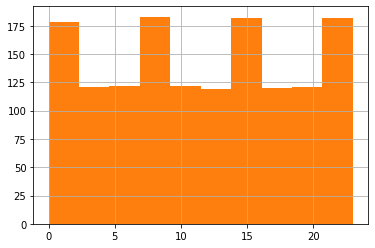

In [ ]:
# 연속형 변수 조사 - 히스토그램
train['hour'].hist() # 시간에 따른 데이터 수(x축:hour, y축:데이터 수)
plt.hist(train['hour']) # 위와 동일

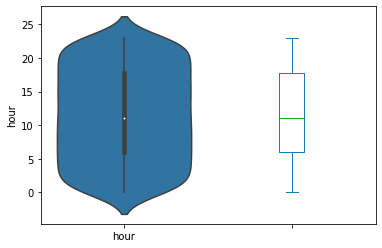

In [ ]:
# 연속형 변수 조사 - 박스플롯, 바이올린플롯 -> 이상치 탐지 목적 -> hour속성에 이상치는 딱히 탐지되지않음.
sns.violinplot(y=train['hour'])
train['hour'].plot(kind='box')

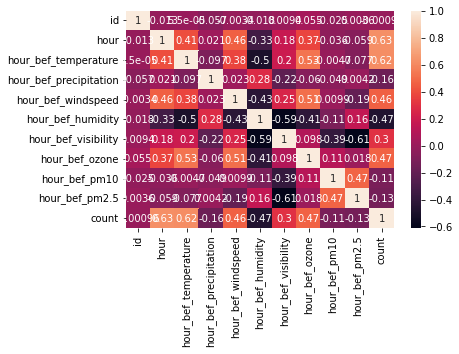

In [ ]:
# 상관관계 조사
train.corr() # 속성 간 상관계수 표
sns.heatmap(train.corr(), annot=True) # 상관계수들 시각화

# 5. Feature Engineering

# 6. 모델 학습

# 7. 모델 평가, 하이퍼 파라미터 최적화

# 8. 모델 사용

# 9. 제출 양식에 맞게 수정후 제출